# Forward Problem

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

## Constants

In [2]:
L = 1.
NX = NY = 128
X_START = 0.
X_END = L
Y_START = 0.
Y_END = L

## Domain

In [3]:
x = jnp.linspace(X_START, X_END, NX + 1)
y = jnp.linspace(Y_START, Y_END, NY + 1)
X, Y = jnp.meshgrid(x, y)

In [4]:
dx = x[1] - x[0]
dy = y[1] - y[0]

## Source Term ($f$) and Solution ($u$) Functions

In [6]:
u = (lambda x, y: jnp.sin(2.*jnp.pi*x) * jnp.sin(2.*jnp.pi*y) +\
                  (1./16.**2) * jnp.sin(32.*jnp.pi*x) * jnp.sin(32.*jnp.pi*y))

f = (lambda x, y: -8 * jnp.pi**2 * jnp.sin(2*jnp.pi*x) * jnp.sin(2*jnp.pi*y) -\
                   8 * jnp.pi**2 * jnp.sin(32.*jnp.pi*x) * jnp.sin(32.*jnp.pi*y))

##  Source Term and Solution

In [7]:
U = u(X, Y)
F = f(X, Y)

### Specifics of the Spectral solver

In [5]:
hx = 2. * jnp.pi / (NX * dx)

In [8]:
m_arr = jnp.empty(NX)
m_arr = m_arr.at[jnp.arange(0, int(NX/2))].set(hx * jnp.arange(0, int(NX/2))) 
m_arr = m_arr.at[jnp.arange(int(NX/2), NX)].set(hx * jnp.arange(-int(NX/2), 0))
n_arr = jnp.copy(m_arr)

In [9]:
u_tilda_den = lambda m, n: (-(m**2 + n**2))
den_jax = jax.vmap(jax.vmap(u_tilda_den, in_axes=(0, None)), in_axes=(None, 0))(m_arr, n_arr)

In [10]:
den_jax = den_jax.at[0,0].set(jnp.finfo(float).eps)

## Solver Function

In [11]:
@jax.jit
def poisson_fft_spectral_direct_solver(F, den):
    U_final = jnp.zeros_like(F)
    F_tilda = jnp.fft.fftn(F[:-1, :-1].astype(complex))
    F_tilda = F_tilda.at[0,0].set(complex(0,0))    
    U_tilda = F_tilda/den
    U_final = U_final.at[:-1, :-1].set(jnp.real(jnp.fft.ifftn(U_tilda)))
    U_final = U_final.at[-1,:].set(U_final[0, :]) # periodic boundary condition handling
    return U_final.at[:,-1].set(U_final[:, 0]) # periodic boundary condition handling

## Validating the solver

In [12]:
U_numerical = poisson_fft_spectral_direct_solver(F, den_jax)

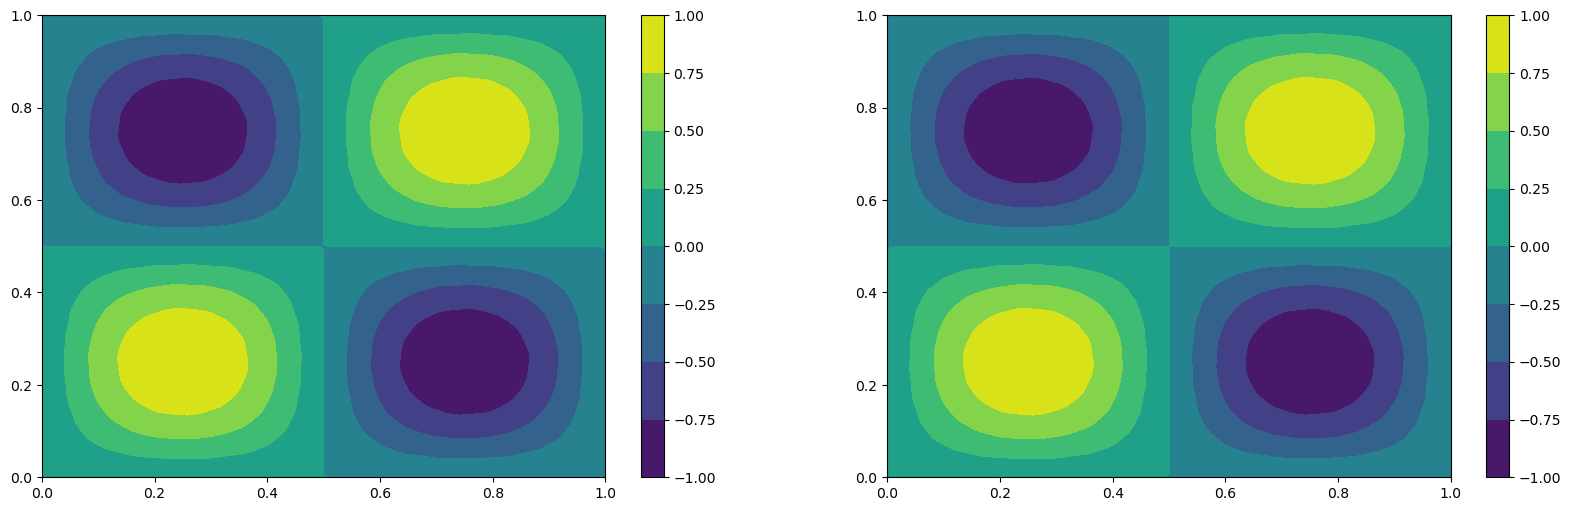

In [13]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
num = axs[0].contourf(X, Y, U_numerical)
gt = axs[1].contourf(X, Y, U)
fig.colorbar(num)
fig.colorbar(gt)
plt.show()

# Inverse Problem
### Technique: Use trainable $f$

In [14]:
import optax

### Defining a trainable source term ($f$) as an OPTAX parameter

In [31]:
rng_key = jax.random.PRNGKey(42)
F_init = {'trainable' : jax.random.normal(rng_key, F.shape)}

## Loss Function

In [35]:
def scalar_loss(F_param, U_num, den):
    input = F_param['trainable']
    U_num_pred = poisson_fft_spectral_direct_solver(input, den)
    return optax.l2_loss(U_num_pred, U_num).mean()

## Fit function for optimizing parameters

In [71]:
def fit(params: optax.Params, optimizer:optax.GradientTransformation, U_num, den, total_steps=10000):
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, U_num, den):
        loss_val, grads = jax.value_and_grad(scalar_loss)(params, U_num, den)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_val
    
    for i in range(total_steps):
        params, opt_state, loss_val = step(params, opt_state, U_num, den)
        if i % 5000 == 0:
            print(f"Loss value at iteration {i} is {loss_val}")
    
    return params

In [72]:
optimizer = optax.adam(learning_rate=1e-2)
F_pred = fit(F_init, optimizer, U_numerical, den_jax, 50_000)

Loss value at iteration 0 is 0.12303689867258072
Loss value at iteration 5000 is 0.006319602485746145
Loss value at iteration 10000 is 0.00044865382369607687
Loss value at iteration 15000 is 6.050245792721398e-05
Loss value at iteration 20000 is 1.3609965208161157e-05
Loss value at iteration 25000 is 8.811854058876634e-06
Loss value at iteration 30000 is 6.722128546243766e-06
Loss value at iteration 35000 is 5.438624611997511e-06
Loss value at iteration 40000 is 4.615429588739062e-06
Loss value at iteration 45000 is 4.0682398321223445e-06


### Extra 20k iterations

In [76]:
F_pred = fit(F_pred, optimizer, U_numerical, den_jax, 20_000)

Loss value at iteration 0 is 3.689219965963275e-06
Loss value at iteration 5000 is 3.414932734813192e-06
Loss value at iteration 10000 is 3.207803274563048e-06
Loss value at iteration 15000 is 3.0452472401520936e-06


## Comparing the results

In [77]:
U_num_pred = poisson_fft_spectral_direct_solver(F_pred['trainable'], den_jax)

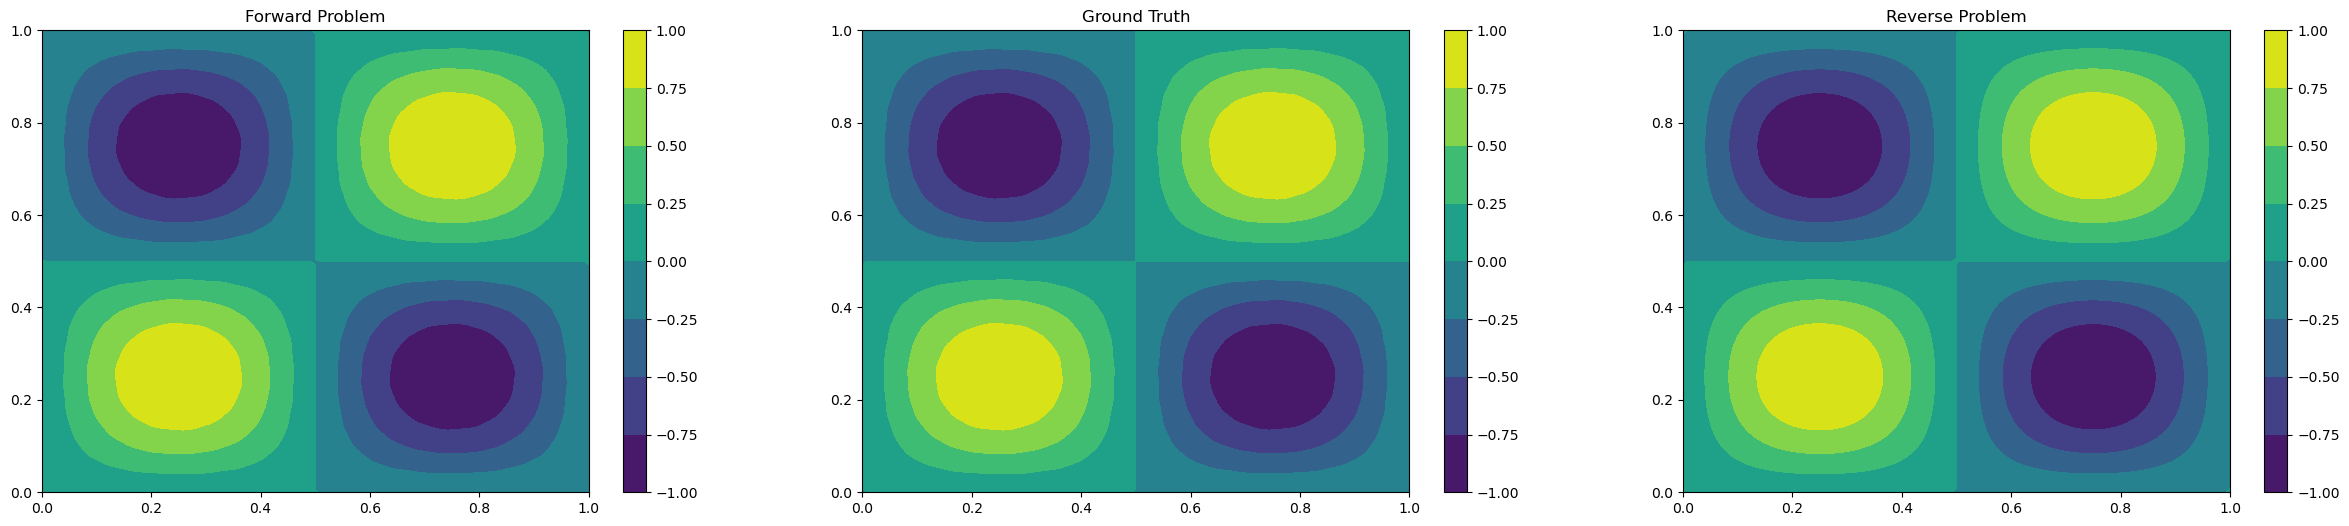

In [90]:
fig, axs = plt.subplots(1,3, figsize=(30,6))
num = axs[0].contourf(X, Y, U_numerical)
gt = axs[1].contourf(X, Y, U)
rev = axs[2].contourf(X, Y, U_num_pred)
axs[0].set_title("Forward Problem")
axs[1].set_title("Ground Truth")
axs[2].set_title("Reverse Problem")
fig.colorbar(num)
fig.colorbar(gt)
fig.colorbar(rev)
plt.show()

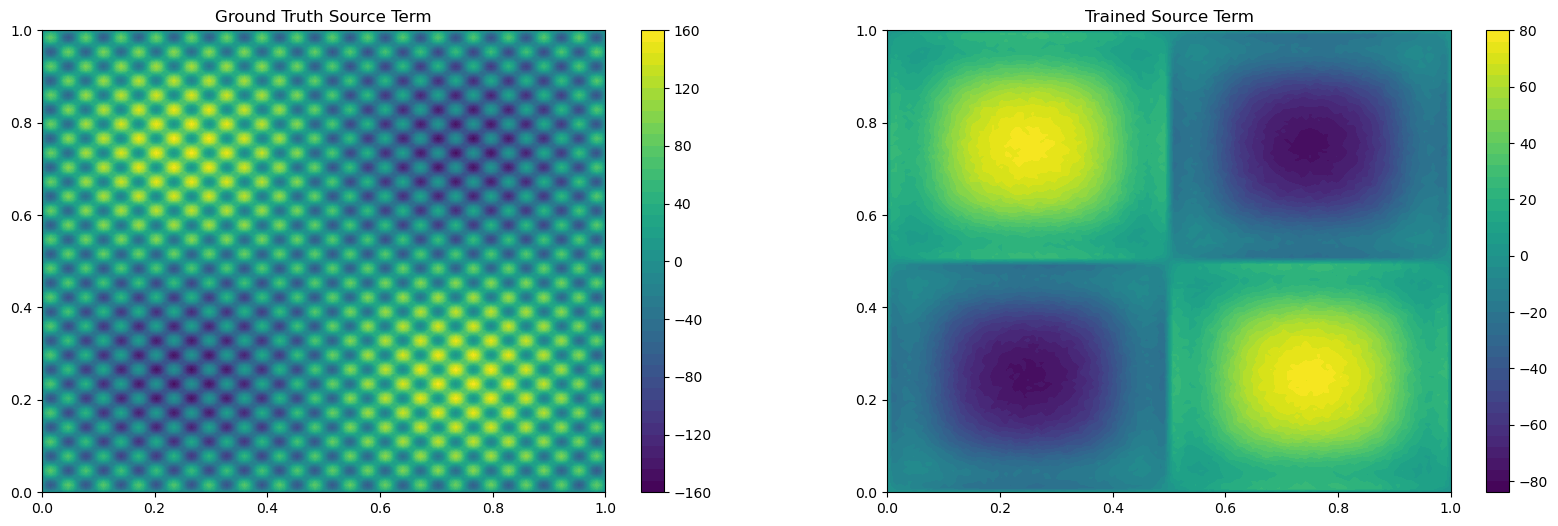

In [91]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
gt = axs[0].contourf(X, Y, F, 50)
rev = axs[1].contourf(X, Y, F_pred['trainable'], 50)
axs[0].set_title("Ground Truth Source Term")
axs[1].set_title("Trained Source Term")
fig.colorbar(gt)
fig.colorbar(rev)
plt.show()